In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import warnings
import os
import lightgbm as lgbm
import gc

warnings.filterwarnings('ignore')
font_name = matplotlib.font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
krfont = {'family':font_name, 'size':10}
matplotlib.rc('font', **krfont)
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
from sklearn.preprocessing import LabelEncoder
def process_dataframe(input_df):
    
    output_df = input_df.copy()
    print('Label encoding categorical features...')
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    encoder_dict = {}
    for feat in categorical_feats:
        encoder = LabelEncoder()
        output_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
        encoder_dict[feat] = encoder
    print('Label encoding complete.')

    return output_df, categorical_feats.tolist(), encoder_dict

In [3]:
input_dir = os.path.join(os.curdir, 'data')

In [4]:
sample_size = None

train = pd.read_csv(os.path.join(input_dir, 'application_train.csv'), nrows=sample_size)
test = pd.read_csv(os.path.join(input_dir, 'application_test.csv'), nrows=sample_size)

In [29]:
train2, categorical_feats, encoder_dict = process_dataframe(train)
test2, categorical_feats, encoder_dict = process_dataframe(test)

Label encoding categorical features...
Label encoding complete.


In [6]:
target = train2.pop('TARGET')
lgbm_train = lgbm.Dataset(data=train2, label=target, categorical_feature=categorical_feats, free_raw_data=False)

In [7]:
lgbm_params = {
    'boosting': 'dart',
    'application': 'binary',
    'learning_rate': 0.1,
    'min_data_in_leaf': 30,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.5,
    'scale_pos_weight': 2,
    'drop_rate': 0.02
}

In [8]:
cv_results = lgbm.cv(train_set=lgbm_train,
                     params=lgbm_params, 
                     nfold=5,
                     num_boost_round=600,
                     early_stopping_rounds=50,
                     verbose_eval=50,
                     metrics=['auc'])

[50]	cv_agg's auc: 0.751748 + 0.00293037
[100]	cv_agg's auc: 0.755708 + 0.00263085
[150]	cv_agg's auc: 0.757131 + 0.00224964
[200]	cv_agg's auc: 0.757698 + 0.00195387
[250]	cv_agg's auc: 0.758104 + 0.00177186
[300]	cv_agg's auc: 0.758424 + 0.00183384
[350]	cv_agg's auc: 0.758669 + 0.00184214


In [27]:
optimum_boost_rounds = np.argmax(cv_results['auc-mean'])

clf = lgbm.train(train_set=lgbm_train,
                params=lgbm_params,
                num_boost_round=optimum_boost_rounds)

In [31]:
y_pred = clf.predict(test2)

In [43]:
train['ORGANIZATION_TYPE'].unique().tolist()

['Business Entity Type 3',
 'School',
 'Government',
 'Religion',
 'Other',
 'XNA',
 'Electricity',
 'Medicine',
 'Business Entity Type 2',
 'Self-employed',
 'Transport: type 2',
 'Construction',
 'Housing',
 'Kindergarten',
 'Trade: type 7',
 'Industry: type 11',
 'Military',
 'Services',
 'Security Ministries',
 'Transport: type 4',
 'Industry: type 1',
 'Emergency',
 'Security',
 'Trade: type 2',
 'University',
 'Transport: type 3',
 'Police',
 'Business Entity Type 1',
 'Postal',
 'Industry: type 4',
 'Agriculture',
 'Restaurant',
 'Culture',
 'Hotel',
 'Industry: type 7',
 'Trade: type 3',
 'Industry: type 3',
 'Bank',
 'Industry: type 9',
 'Insurance',
 'Trade: type 6',
 'Industry: type 2',
 'Transport: type 1',
 'Industry: type 12',
 'Mobile',
 'Trade: type 1',
 'Industry: type 5',
 'Industry: type 10',
 'Legal Services',
 'Advertising',
 'Trade: type 5',
 'Cleaning',
 'Industry: type 13',
 'Trade: type 4',
 'Telecom',
 'Industry: type 8',
 'Realtor',
 'Industry: type 6']

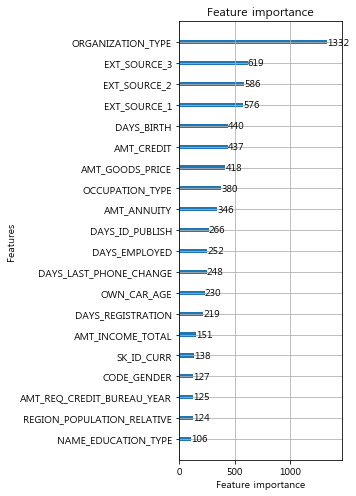

In [38]:
fig, ax = plt.subplots(1, 1, figsize=[5, 7])
lgbm.plot_importance(clf, ax=ax, max_num_features=20)
plt.tight_layout()